<a href="https://colab.research.google.com/github/Raghuram-Veeramallu/Bayesian-Astrostat/blob/project1/Project%201/Project1_Group3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AST/STAT 5731 Project 1

**Group: 3**  
Hari Veeramallu  
Nicholas Kruegler  
Daniel Warshofsky  
Jonah Koleske  

## Research Question  

What is the fraction of binary stars in the Globular Cluster NGC 5053?

##Preamble

The dynamical evolution of a globular cluster (GC) can be impacted by the binary fraction, which is a measurement of the percent of the stars in a GC that are binary systems. Even a small binary fraction can have a large influence by cooling the cluster and pushing the system towards a higher mass concentration. This GC was chosen because a previous survey was carried out that found a sample of binary stars, and the detection rate bias parameter was determined for this galaxy, so we can adjust the recorded rate with the rate that would go undetected.

## Data

All the observations were made with the Norris Multifibre Spectrograph on the Hale 5.0 m telescope. A total of 6 epochs of a sample of 77 cluster member stars with a total timespan of 3 years was observed.

##1. Explain the Model

###Data Variables
1. $\theta$, the probability that the star system is binary.  
2. $\theta \in [0, 1]$  
3. $ x = 6, n = 66 $  
4. $ X \in \{0, 1\}^{n} $  
5. $ X | \theta  \in Binomial(n, \theta) $  
6. Given $ a > 0, b > 0 $, then $ \theta \sim Beta(a, b) $ (since beta is the conjugate prior of binomial).


###Likelihood Function
The sample space for observed data is a binary answer: either a star system is binary or it isn’t. Thus, we would expect it to follow a binomial distribution, which will be the model used in the statistical analysis.

For a binomial distribution, the expectation value is:
$E[X]=n\theta$

The variance is:
$Var[X]=n\theta (1-\theta)$

###Prior Distribution
A beta distribution is used for the prior, since the beta distribution is the conjugate prior for the binomial distribution. This makes the analytical calculation of the posterior possible, without relying on Monte Carlo computations. There is already previous knowledge about the binary fraction in the Milky Way, where this specific globular cluster NGC 5053 is found, so we have information for a prior.

For a beta distribution $Beta(a,b)$, the expectation value is:
$E[X] = \frac{a}{a+b}$

The variance is:
$Var[X] = \frac{ab}{(a+b)^2 (a+b+1)}$

###Posterior Distribution
Because the likelihood is a binomial distribution and we have assumed the prior to be a beta function, the posterior distribution can be found analytically.

Posterior is $\theta|x \sim Beta(a+x, n+b-x)$

The posterior expectation value will be:
$E[X] = \frac{a+x}{a+b+n}$


###Decisions about Data
The paper (https://arxiv.org/pdf/astro-ph/9607116.pdf) data from 77 stars NGC 5053 but only 66 had enough radial velocity measurements to determine if they are binary so analysis is restricted to only those stars. For one binary star (candadate ST) the authors were unsure of its membership to the cluster and counted it as being 0.5 of a binary, in our analysis we will count it as a full binary. Our analysis has $x=6$ where as the authors would have $x=5.5$.

###Possible Bias and Correction
The radial velocity method is only sensitive to the radial motion of the stars so systems that are face-on will not be detected, in the paper the authors preform a simulation to determinne how many systems they were likely to discover. After their anaylsis they determined that they would have discovered 29% of binaries.

###Prior Predictive Check

##Code and Computation Details

#### 1. Loading the data and Visualizing them

In [42]:
## Importing the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from random import seed

# import required only for google colab runtime
from google.colab import drive

# for darkgrid visualizations
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
## Reading the data

# for local runtime
# df = pd.read_table('./content/BinaryStarsNGC5053.tsv')

# for google drive (https://drive.google.com/drive/folders/1hatW5Gb4E7PtSTrPNSCLFlFZZkixh5F9?usp=sharing)
drive.mount('/content/drive')
df = pd.read_table('drive/MyDrive/BayesianAstrostat/Project1/BinaryStarsNGC5053.tsv')

Mounted at /content/drive


In [3]:
## Looking at the data
df.sample(10)

,Star,Dist,VR,chi2,P(<chi2)
72,S70,252.2,290.8,0.448,0.5033
32,S109,267.4,297.5,23.300,0.0003
33,S72,435.0,294.4,0.265,0.6068
25,LY043,182.4,288.2,2.945,0.2294
28,LY065,235.9,295.0,0.953,0.3290
37,S106,418.2,296.9,1.742,0.1868
65,LY40,125.5,290.7,0.578,0.4469
60,LY109,308.3,293.0,0.998,0.3178
66,S27,28.4,294.8,2.735,0.0982
59,LY08,248.5,291.4,0.588,0.4432


**Data Description:**  
*Star* - Name of the star system.  
*Dist* - Radial distance of the star from the cluster  
*VR* - Weighted Mean Radial Velocity.  
*chi2* - Radial Velocity variability over the timespan of 3 years.  
*P(<chi2)* - Probability  

The P(*<chi2*) is calculated to estimate the probability of having the chi2 at least this large purely due to a chance of fluctuations. Reasonable limits of P(*<chi2*) to identify significant variations are 0.01 - 0.001

In [4]:
# Looking at the statistics of the data
df.describe()

,Dist,VR,P(<chi2)
count,77.000000,77.000000,66.000000
mean,210.640260,291.355844,0.478300
std,117.873282,2.339562,0.288685
min,15.200000,286.600000,0.000000
25%,125.100000,290.000000,0.265450
50%,205.400000,291.000000,0.498950
75%,275.800000,292.500000,0.711400
max,513.900000,299.200000,0.942000


Within these stars the binary stars are defined as the ones having *P(<chi2)* $\lt 0.01$.  

In [5]:
# Number of star systems with a single radial velocity observations
sin_obs = df[df['P(<chi2)'].isna()]
# Number of star systems with more than one radial velocity observations
mul_obs = df[~df['P(<chi2)'].isna()]
# Number of binary stars within the star systems with more than one radial velocity observations
bin_stars = mul_obs[mul_obs['P(<chi2)'] < 0.01]

In [6]:
print(f'Total number of star systems present: {len(df)}')
print(f'Number of star systems having only a single Radial Velocity measurement: {len(sin_obs)}')
print(f'Number of star systems having multiple Radial Velocity measurements: {len(mul_obs)}')
print(f'Number of binary stars among the ones with multiple RV measurements: {len(bin_stars)}')

Total number of star systems present: 77
Number of star systems having only a single Radial Velocity measurement: 11
Number of star systems having multiple Radial Velocity measurements: 66
Number of binary stars among the ones with multiple RV measurements: 6


From the description we can see that only 66 out of the 77 can be used for binary search since the remaining 11 only have a single radial velocity measurement observed.

### 2. Visualizing the data

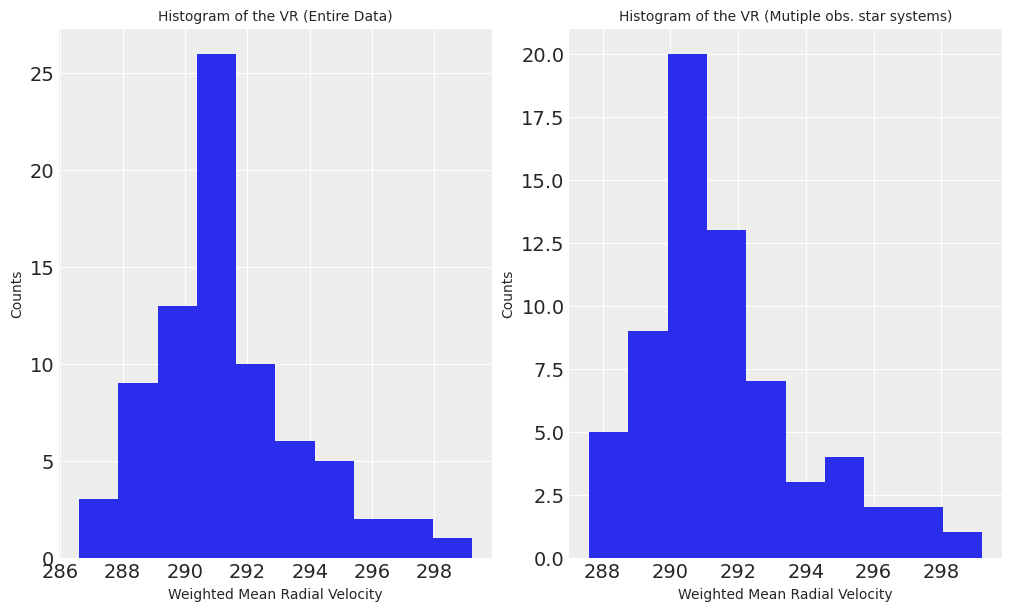

In [14]:
# histogram of Weighted Mean Radial Velocities (VR)
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].hist(df['VR'])
ax[0].set_xlabel('Weighted Mean Radial Velocity', size = 10)
ax[0].set_ylabel('Counts', size = 10)
ax[0].set_title('Histogram of the VR (Entire Data)', size = 10)
ax[1].hist(mul_obs['VR'])
ax[1].set_xlabel('Weighted Mean Radial Velocity', size = 10)
ax[1].set_ylabel('Counts', size = 10)
ax[1].set_title('Histogram of the VR (Mutiple obs. star systems)', size = 10)

plt.show()

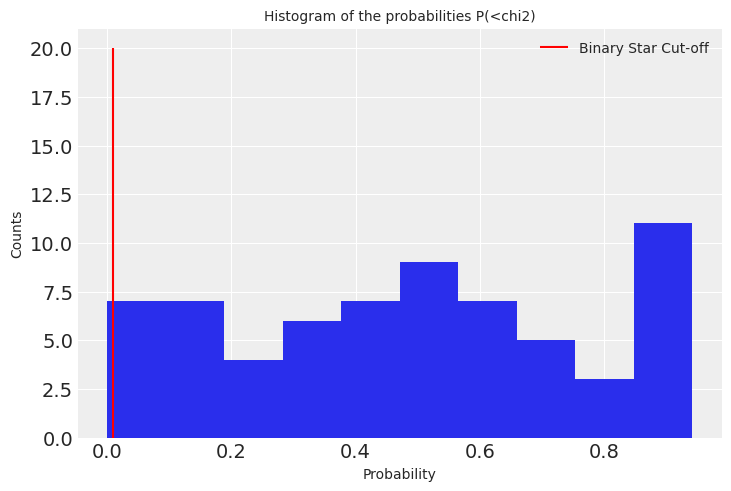

In [ ]:
plt.hist(mul_obs['P(<chi2)'])
plt.vlines(0.01, 0, 20, label = "Binary Star Cut-off", color='r')
plt.xlabel('Probability', size=10)
plt.ylabel('Counts', size=10)
plt.title('Histogram of the probabilities P(<chi2)', size=10)
plt.legend(prop={'size': 10})
plt.show()

### 3. Model

1. $\theta$, the probability that the star system is binary.  
2. $\theta \in [0, 1]$  
3. $ x = 6, n = 66 $  
4. $ X \in \{0, 1\}^{n} $  
5. $ X | \theta  \in Binomial(n, \theta) $  
6. Given $ a > 0, b > 0 $, then $ \theta \sim Beta(a, b) $ (since beta is the conjugate prior of binomial).

Posterior is $\theta|x \sim Beta(a+x, n+b-x)$  

$E[X] = \frac{a}{a+b}$  

$Var[X] = \frac{ab}{(a+b)^2 (a+b+1)}$  

Assuming that the probability of a star system is binary is uniform, a = 1, b = 1

That would make the posterior $ => $ $ \theta | x \sim Beta(7, 61) $  
and $E[X] = \frac{1}{2} , Var[X] = \frac{1}{12} $

In [45]:
nobs = len(mul_obs)
nbin_obs = len(bin_stars)

$a' = a + x$  
$b' = n + b - x$

## Prior Predictive Check

In [28]:
# Defining a function to perform prior predictive check
def prior_pred(a, b, samples):
  mean = []
  var = []
  np.random.seed(5731)
  fig,ax = plt.subplots(1,1,figsize=(6,4))
  for i in range(samples):
    theta = stats.beta.rvs(a,b,size=1)
    simdat = stats.binom.rvs(nobs,theta,size=66)
    mean.append(np.mean(simdat))
    var.append(np.var(simdat))

  ax.hist(mean)
  ax.set_xlabel('Star Systems', size=10)
  ax.set_ylabel('Counts', size=10)
  ax.set_title(f"Number of Binary Systems out of 66 systems (N={samples} Samples)", size = 12)
  ax.axvline(6, c="r")
  ax.legend(["Actual Observed Number"], prop={'size': 10})

  fig.show()

  return np.median(mean), np.median(var)

(32.56060606060606, 11.88957759412305)

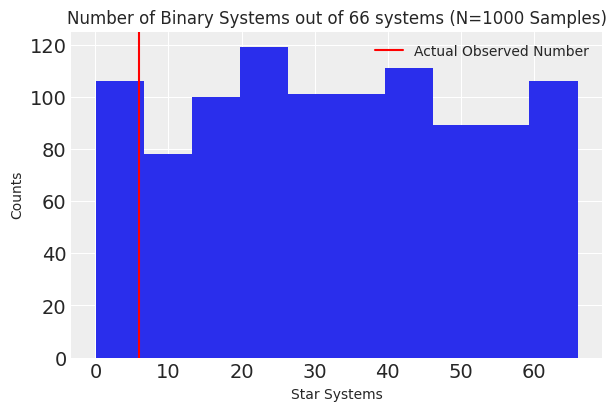

In [29]:
prior_pred(1,1,1000)

(1.9545454545454546, 1.825642791551882)

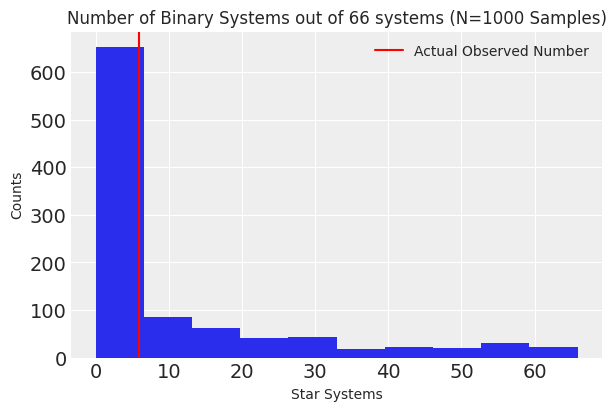

In [30]:
prior_pred(0.2,1,1000)

(10.121212121212121, 8.216483011937559)

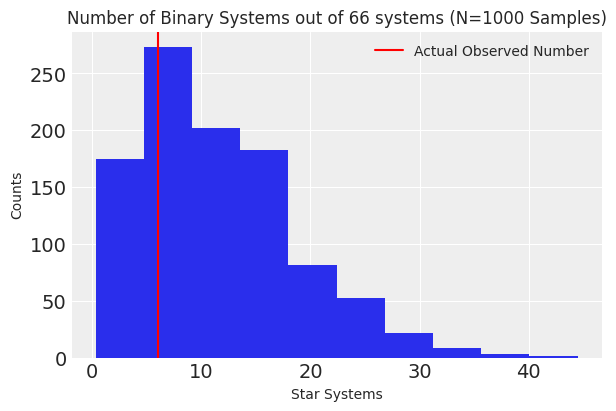

In [31]:
prior_pred(2,10,1000)

(10.287878787878787, 8.415518824609734)

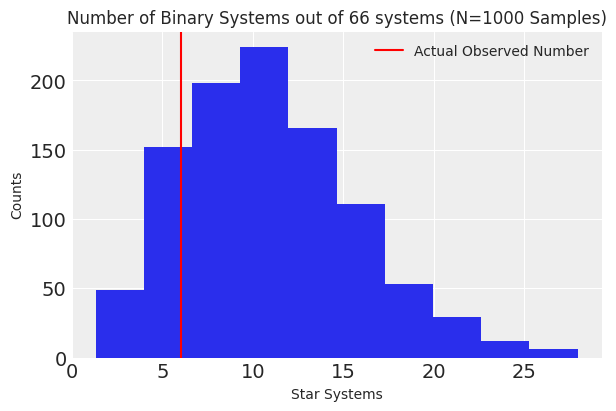

In [32]:
prior_pred(4,20,1000)

In [35]:
# function to plot the distributions
def plot_beta_curves(a, b):
  a_bar = a + nbin_obs
  b_bar = nobs + b - nbin_obs
  print(f'a\': {a_bar}, b\': {b_bar}')

  post_mean = a_bar / (a_bar + b_bar)
  post_var = (a_bar * b_bar)/((a_bar + b_bar) ** 2 * (a_bar + b_bar + 1))
  print(f'Actual Mean: {round(post_mean, 4)} and Posterior Variance: {round(post_var, 4)}')
  print(f'Posterior Mean: {round(post_mean, 4)} and Posterior Variance: {round(post_var, 4)}')

  post_lb = stats.beta.ppf(0.01, a_bar, b_bar)
  post_ub = stats.beta.ppf(0.99, a_bar, b_bar)
  print(f'Lower bound: {round(post_lb, 4)} and Upper bound: {round(post_ub, 4)}')

  x1 = np.linspace(stats.beta.ppf(0.01, 1, 1), stats.beta.ppf(0.99, 1, 1), 100)
  y1 = stats.beta.pdf(x1, a, b)
  plt.plot(x1, y1, color='r', ls='--', label='prior')

  x2 = np.linspace(stats.beta.ppf(0.01, a_bar, b_bar), stats.beta.ppf(0.99, a_bar, b_bar), 100)
  y2 = stats.beta.pdf(x2, a_bar, b_bar)
  plt.plot(x2,y2, label='posterior')
  # plt.axvline(post_mean, color='b', ls='--', label='posterior mean')

  plt.axvline(6/66,c="r")
  plt.title("a={}, b={}".format(a,b))
  plt.legend()
  plt.show()

a': 8, b': 70
Posterior Mean: 0.1026 and Posterior Variance: 0.0012
Lower bound: 0.0388 and Upper bound: 0.1959


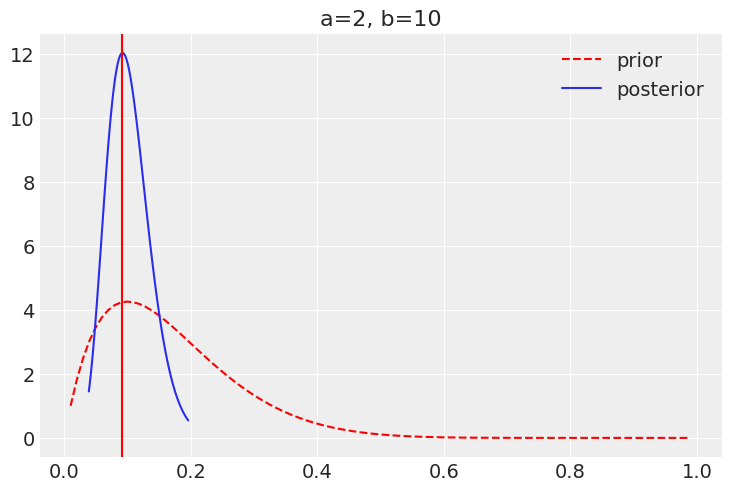

In [36]:
plot_beta_curves(2, 10)

## Sensitivity Analysis

We are selecting different values of a, b and see how much they influence the posterior.

a': 7, b': 70
Posterior Mean: 0.0909 and Posterior Variance: 0.0011
Lower bound: 0.0314 and Upper bound: 0.1811


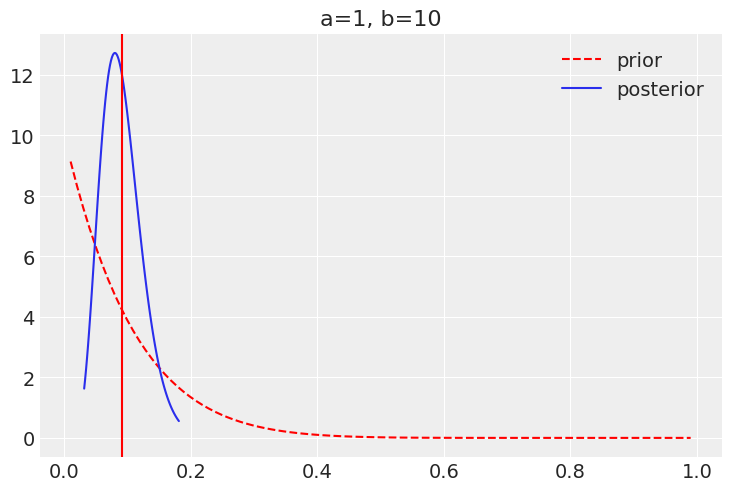

In [37]:
plot_beta_curves(1, 10)

a': 8, b': 80
Posterior Mean: 0.0909 and Posterior Variance: 0.0009
Lower bound: 0.0342 and Upper bound: 0.1745


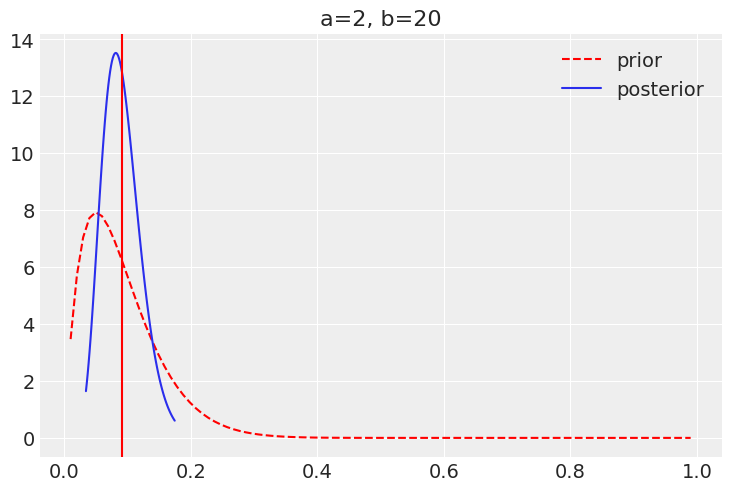

In [52]:
plot_beta_curves(2, 20)

a': 8, b': 72
Posterior Mean: 0.1 and Posterior Variance: 0.0011
Lower bound: 0.0378 and Upper bound: 0.1912


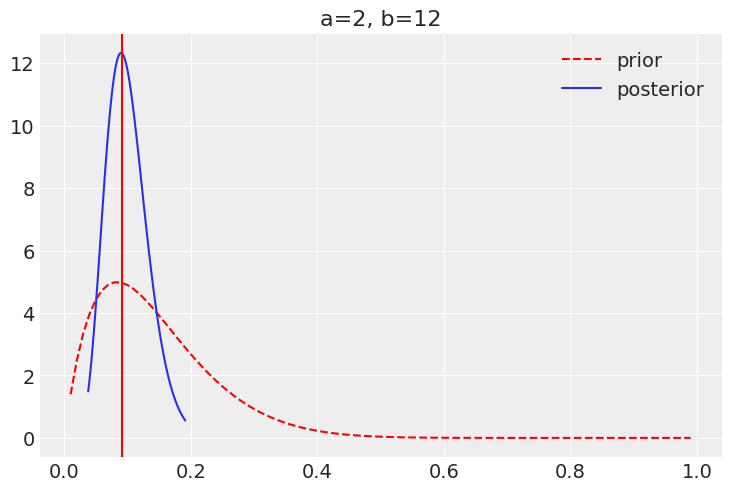

In [53]:
plot_beta_curves(2, 12)

a': 8, b': 73
Posterior Mean: 0.0988 and Posterior Variance: 0.0011
Lower bound: 0.0373 and Upper bound: 0.1889


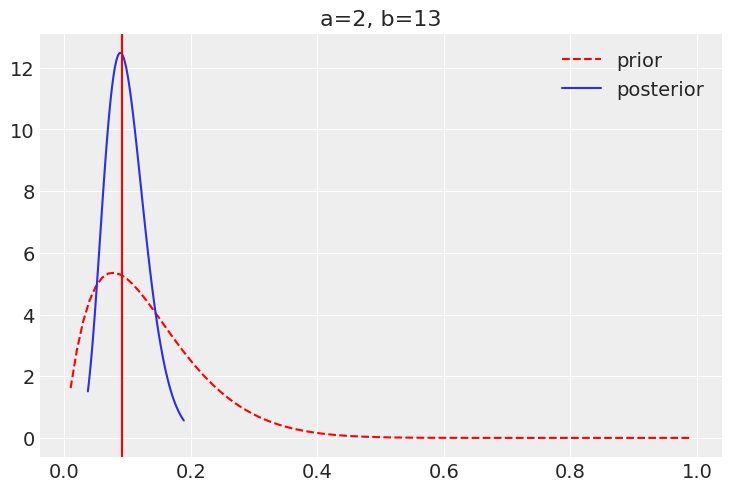

In [56]:
plot_beta_curves(2, 13)

a': 16, b': 260
Posterior Mean: 0.058 and Posterior Variance: 0.0002
Lower bound: 0.0301 and Upper bound: 0.0952


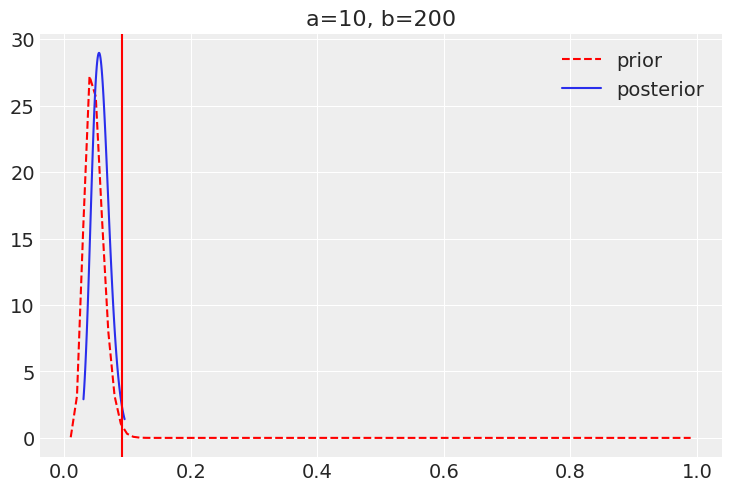

In [49]:
plot_beta_curves(10, 200)

In [ ]:
def post_pred(a, b, samples):
  mean = []
  var = []
  np.random.seed(5731)
  fig,ax = plt.subplots(1,1,figsize=(6,4))
  for i in range(samples):
    theta = stats.beta.rvs(a,b,size=1)
    simdat = stats.binom.rvs(nobs,theta,size=66)
    mean.append(np.mean(simdat))
    var.append(np.var(simdat))

  ax.hist(mean)
  ax.set_title("Number of Binary Systems out of 66 systems (N={} Samples)".format(samples))
  ax.axvline(6,c="r")
  ax.legend(["Actual Observed Number"])

  return np.median(mean), np.median(var)